In [36]:
%load_ext autoreload 
%autoreload 1
%aimport models, utils
from importlib import reload
reload(models.contrastive)
reload(utils.linear)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.linear' from '/home/theo/Documents/TCC-EEG/utils/linear.py'>

In [1]:
import mne
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.datasets import BaseConcatDataset, WindowsDataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skorch.callbacks import EpochScoring, ProgressBar
from skorch.helper import predefined_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import torch

from utils.datasets import get_sleep_physionet, split_dataset, list_of_train_sets, TimeContrastiveDataset
from utils.skorch import EEGTransformer
from utils.linear import plot_knn, compute_dist_to_knn
from utils.plot import (sleep_cmap, rand_cmap, plot_embeddings, get_ages, get_sleep_stages, get_subjects, get_recording, get_sex)
from models.contrastive import ContrastiveModule, EncoderNet, ClassifierNet, train_and_test

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
%%capture
# full dataset, to get a small one, use: get_sleep_physionet(range(10))
windows_dataset, info = get_sleep_physionet()

In [4]:
self_train_set, self_valid_set, full_train_set, valid_set, test_set, subjects_dic = split_dataset(windows_dataset)
print(len(self_train_set), len(self_valid_set), len(full_train_set), len(valid_set), len(test_set))

115813 17622 133435 16156 18058


In [5]:
splitted = windows_dataset.split('subject')
all_valid_set = TimeContrastiveDataset([splitted[s] for s in subjects_dic['self_valid_subjects'] + subjects_dic['valid_subjects']], delta_index_positive=5, delta_index_negative=20)

In [6]:
mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 4': 3,
    'Sleep stage 3': 3,
    'Sleep stage R': 4
}
reverse_mapping = {v: k[-1] for k,v in mapping.items()}

# Noise generation

In [8]:
network = torch.load('contrastive_network.pt')
encoder = network.encoder
with open('contrastive_network.pkl', 'rb') as f:
    skorch_net = pickle.load(f)

In [9]:
def make_cov(info, std=0.2e-6, verbose=None):
    picks = mne.pick_types(info, meg=True, eeg=True, exclude=())
    if type(std) in [float, np.float32, np.float64]:
        data = np.array([std*std]*len(picks))
    else:
        data = np.array(std)
    ch_names = [info['ch_names'][pick] for pick in picks]
    return mne.Covariance(data, ch_names, info['bads'], info['projs'], nfree=0)

In [17]:
from IPython.utils import io

def add_noise(windows_dataset, subject_id, recording_id, new_idx, noise_std=0.2, seed=None):
    selected_dataset = windows_dataset.datasets[np.where((windows_dataset.description['subject'] == subject_id) & (windows_dataset.description['recording'] == recording_id))[0][0]]
    selected_windows = selected_dataset.windows.copy()
    cov = make_cov(selected_dataset.windows.info, std=noise_std, verbose=None)
    with io.capture_output() as captured:
        epochs_noise = mne.simulation.add_noise(selected_windows, cov, iir_filter=[4, -4, 0.8], random_state=seed)
    description_noise = pd.Series({'subject':subject_id, 'recording':new_idx})
    return WindowsDataset(epochs_noise, description_noise)

## Fixed seed -> controled noise with interpolation between std=0. and std=2.

In [68]:
noise_level = 0.1
nb_noise = 20

noise = np.array([noise_level*i for i in range(1,nb_noise+1)])
noise_subject = [add_noise(windows_dataset, subject_id=80, recording_id=1, new_idx=2+i+1, noise_std=n, seed=seed) for i,n in enumerate(tqdm(noise))]

noise_one_channel = np.array([[[noise_level*i,0.],[0.,0.]] for i in range(1,nb_noise+1)])
noise_subject_mono = [add_noise(windows_dataset, subject_id=80, recording_id=1, new_idx=2+i+1, noise_std=n, seed=seed) for i,n in enumerate(tqdm(noise_one_channel))]

noise_dataset = BaseConcatDataset(noise_subject + noise_subject_mono)

In [69]:
noise_set = TimeContrastiveDataset(all_valid_set.datasets + noise_dataset.datasets)
embds_noise = skorch_net.transform(noise_set)[::2]

In [82]:
sleep_stages_noise = get_sleep_stages(noise_set)
ages_noise = get_ages(noise_set, info)
subjects_noise = get_subjects(noise_set)
recording_noise = get_recording(noise_set)
sex_noise = get_sex(noise_set, info)
type_noise = np.array([0]*len(all_valid_set) + [1]*(len(noise_subject[0])*20) + [2]*(len(noise_subject_mono[0])*20))

In [72]:
# Only keep some noisy embeddings for visualization with PCA and TSNE
keep_subsample = (recording_noise[:,None]==np.array([1,2,6,11,16,22])).any(axis=1)

In [22]:
# PCA
pca_noise = PCA(2, random_state=seed).fit(embds_noise[keep_subsample])
pca_embds_noise = pca_noise.transform(embds_noise)

In [32]:
# TSNE
tsne_noise = TSNE(2, random_state=seed, n_jobs=-1)
tsne_embds_noise = tsne_noise.fit_transform(embds_noise[keep_subsample])

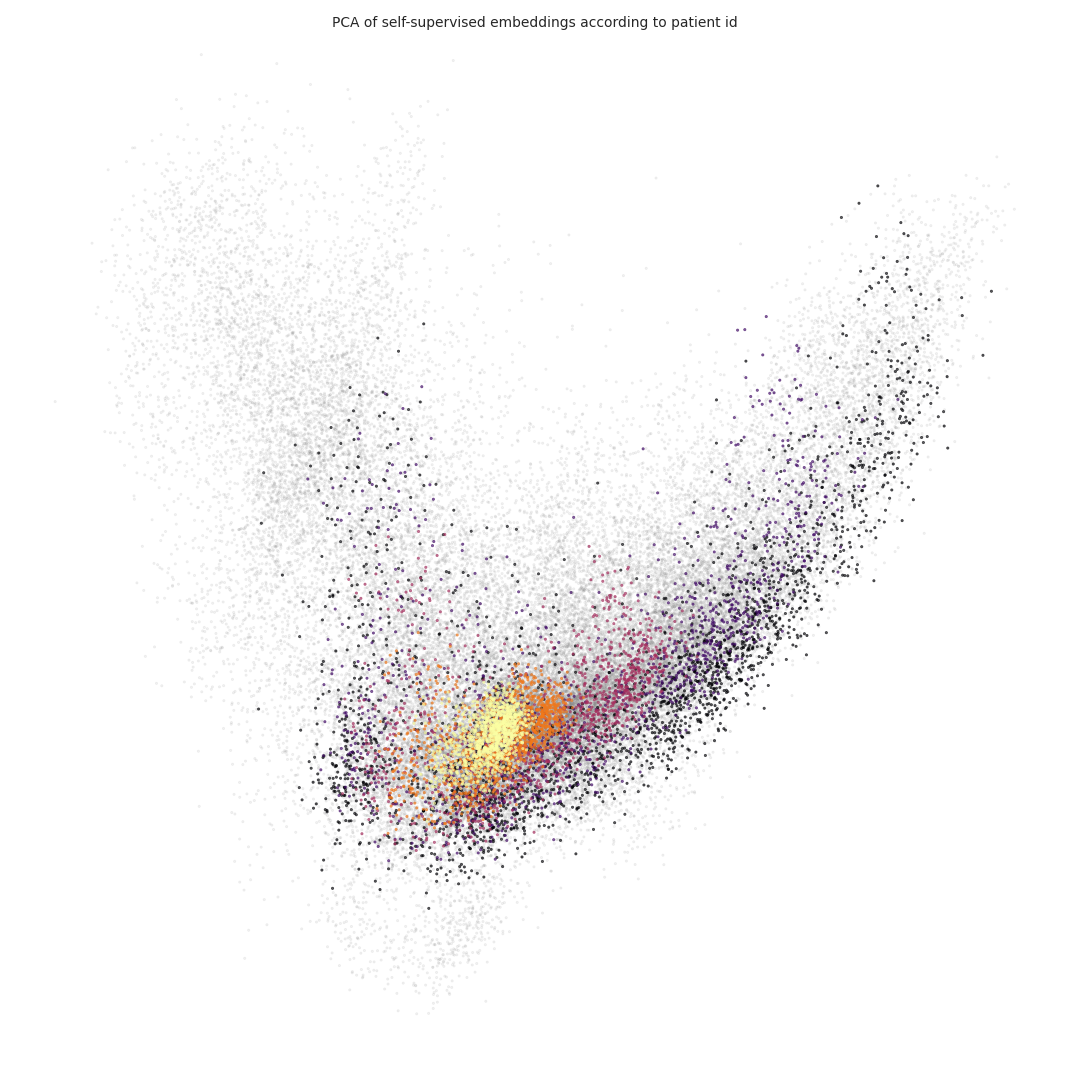

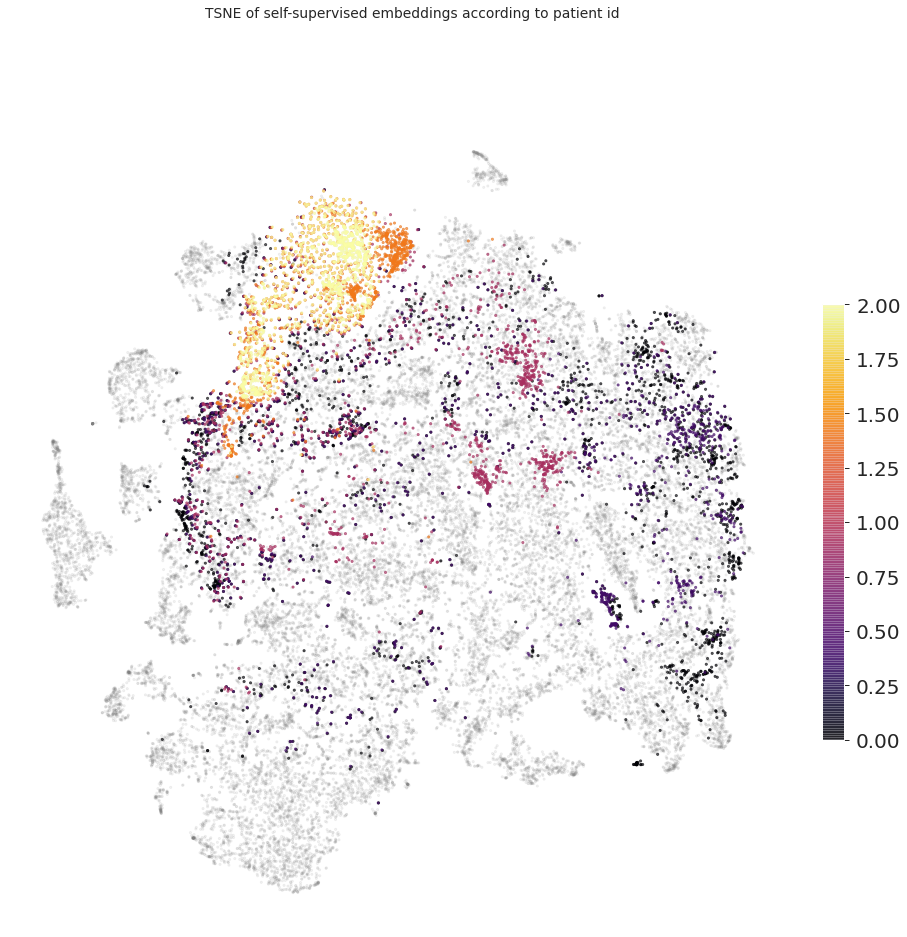

In [41]:
fig = plt.figure(figsize=(15,15))
plot_embeddings(pca_embds_noise, subjects_noise, ['grey'], s=5, alpha=0.1, colorbar=False)
im = plot_embeddings(pca_embds_noise[(subjects_noise==80) & keep_subsample],
                     [np.concatenate([[0,0],noise])[i-1] for i in recording_noise[(subjects_noise==80) & keep_subsample]],
                     plt.get_cmap('inferno'), s=5, alpha=0.6, colorbar=False)
plt.tight_layout()
plt.savefig('img/PCA_patient_noise.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('PCA of self-supervised embeddings according to patient id');

fig = plt.figure(figsize=(15,15))
plot_embeddings(tsne_embds_noise, subjects_noise[keep_subsample], ['grey'], s=5, alpha=0.1, colorbar=False)
im = plot_embeddings(tsne_embds_noise[(subjects_noise==80)[keep_subsample]],
                     [np.concatenate([[0,0],noise])[i-1] for i in recording_noise[(subjects_noise==80) & keep_subsample]],
                     plt.get_cmap('inferno'), s=5, alpha=0.6, colorbar=False)

cbar = plt.colorbar(im,fraction=0.026, pad=0.04)
cbar.ax.tick_params(labelsize=20)

plt.savefig('img/TSNE_patient_noise.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('TSNE of self-supervised embeddings according to patient id');

### Better visualization with UMAP

In [23]:
# UMAP can be fit on a subsample and then transform the whole dataset
# Thus, we fit it on the original dataset, and then transform the noisy EEG
import umap
trans = umap.UMAP(n_neighbors=5, random_state=seed, n_jobs=-1).fit(embds_noise[recording_noise <= 2])

In [73]:
umap_embds_noise = trans.transform(embds_noise)

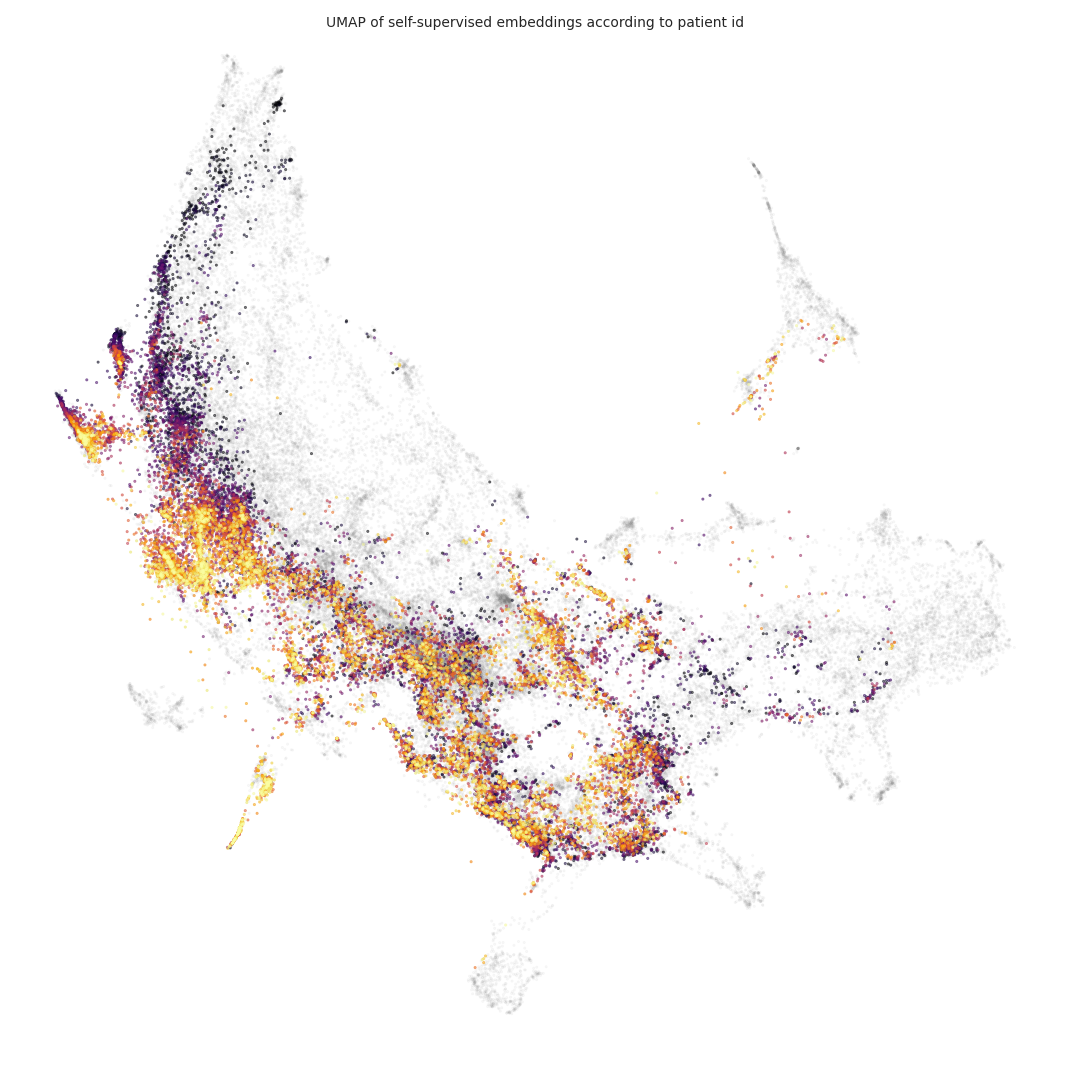

In [100]:
fig = plt.figure(figsize=(15,15))
plot_embeddings(umap_embds_noise, subjects_noise, ['grey'], s=5, alpha=0.05, colorbar=False)
im = plot_embeddings(umap_embds_noise[(subjects_noise==80) & (recording_noise != 2) & (type_noise == 2)],
                     [np.concatenate([[0,0],noise])[i-1] for i in recording_noise[(subjects_noise==80) & (recording_noise != 2) & (type_noise == 2)]],
                     plt.get_cmap('inferno'), s=5, alpha=0.5, colorbar=False)

#cbar = plt.colorbar(im,fraction=0.026, pad=0.04)
#cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('img/UMAP_patient_noise_mono.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('UMAP of self-supervised embeddings according to patient id');

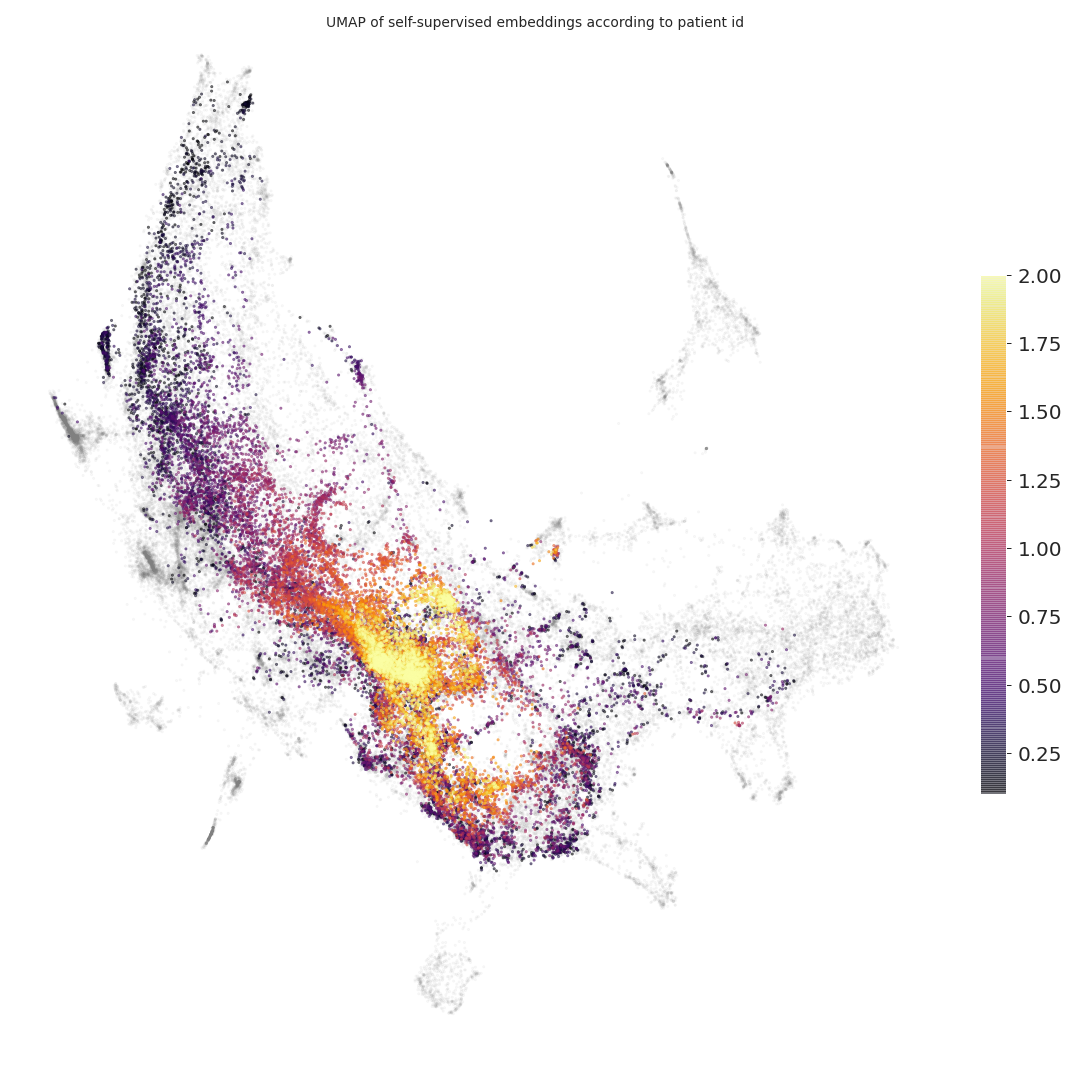

In [99]:
fig = plt.figure(figsize=(15,15))
plot_embeddings(umap_embds_noise, subjects_noise, ['grey'], s=5, alpha=0.05, colorbar=False)
im = plot_embeddings(umap_embds_noise[(subjects_noise==80) & (recording_noise != 2) & (type_noise == 1)],
                     [np.concatenate([[0,0],noise])[i-1] for i in recording_noise[(subjects_noise==80) & (recording_noise != 2) & (type_noise == 1)]],
                     plt.get_cmap('inferno'), s=5, alpha=0.5, colorbar=False)

cbar = plt.colorbar(im,fraction=0.026, pad=0.04)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('img/UMAP_patient_noise.png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.suptitle('UMAP of self-supervised embeddings according to patient id');

In [88]:
dist_list = []
for record_id in range(1,nb_noise+3):
    if record_id==2:
        continue
    distances = compute_dist_to_knn(embds_noise[(subjects_noise==80) & (recording_noise==record_id) & (type_noise == 1)], k='auto')
    dist_list.append(np.mean(distances))
dist_list = np.array(dist_list)

dist_list_mono = []
for record_id in range(1,nb_noise+3):
    if record_id==2:
        continue
    distances = compute_dist_to_knn(embds_noise[(subjects_noise==80) & (recording_noise==record_id) & (type_noise == 2)], k='auto')
    dist_list_mono.append(np.mean(distances))
dist_list_mono = np.array(dist_list_mono)

Warning, k==0
Warning, k==0


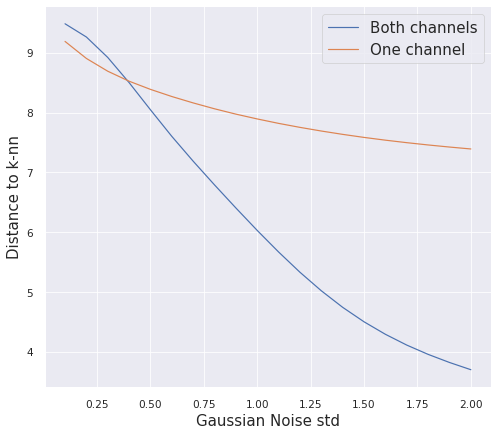

In [97]:
plt.plot([0.] + list(noise), dist_list)
plt.plot([0.] + list(noise), dist_list_mono)
plt.legend(['Both channels', 'One channel'], prop={'size':15})
plt.xlabel('Gaussian Noise std', fontsize=15)
plt.ylabel('Distance to k-nn', fontsize=15)
plt.savefig('img/dist_noise.png', dpi=200, bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))